In [1]:
import torch
import torch.nn as nn
import os
import logging
import numpy as np
from tqdm.auto import tqdm
from Model import Patchify, ExtraMAEDecoder, ExtraMAEEncoder, ExtraMAE
from util import random_indexes, take_indexes
from einops import repeat, rearrange
import matplotlib.pyplot as plt
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration

from accelerate import DistributedDataParallelKwargs
from safetensors.torch import load_model
from diffusion.util import instantiate_from_config
from diffusers.optimization import get_scheduler
from ai4ha.util import instantiate_from_config, load_config, load_config_yaml
from ai4ha.util.train import get_most_recent_checkpoint

In [2]:
def sampling_MAE(
    device,
    model,
    dataset,
    nsamp,
):
    """ _Samplig from the ExtraMAE model_

    Passes random samples through the model, reconstructs the data and saves
    the samples and labels.
    """
    lsamples = []
    llabels = []
    lorig = []
    samples = np.random.randint(0, len(dataset), (nsamp, ))
    print(samples)
    for i in tqdm(samples):
        data, label = dataset[i]
        lorig.append(data)
        pred, mask = model(torch.tensor(data).unsqueeze(0).float().to(device))
        pred = pred.cpu().detach().numpy()
        mask = mask.cpu().detach().numpy()
        data = data * np.abs(mask - 1)
        pred_mask = pred * mask
        pred_mask = pred_mask + data
        lsamples.append(pred_mask)
        llabels.append(label)
    return np.concatenate(lsamples),  llabels

In [2]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [3]:
DIRS = ['checkpoints', 'logs', 'samples', "final", "model"]
logger = get_logger(__name__, log_level="INFO")

In [4]:
exp_dir = '/home/bejar/bsc/misiones/Series/Models/ExtraMAE/'
name = 'PTBXLC-b128-AE-ExtraMAE_l6_h2_p10_m0.75_e256-OPT-adamw-lr5-LS-MSE'

In [5]:
BASE_DIR = f"{exp_dir}/logs/{name}"

In [6]:
config = load_config_yaml("conf/model/PTBXLC-ExtraMAE-L6-H2-P10-E256-M75")
model = ExtraMAE(
    in_channels=config["in_channels"],
    series_length=config["series_length"],
    mask_percent=config["mask_percent"],
    num_layers=config["layers"],
    num_heads=config["heads"],
    embed_dimension=config["embed_dim"],
    patch_size=config["patch_size"],
)

In [7]:
# checkpoint = torch.load(
#     '/home/bejar/bsc/misiones/Series/Models/ExtraMAE/logs/ExtraMAE-MITBIH-L6-H2-P8-E256-M75-LR4//model/model/model.safetensors')
# model.load_state_dict(checkpoint)

load_model(model, '/home/bejar/bsc/misiones/Series/Models/ExtraMAE/logs/PTBXLC-b128-AE-ExtraMAE_l6_h2_p10_m0.75_e256-OPT-adamw-lr5e-05-LS-MSE/final/model.safetensors')

(set(), [])

In [8]:
model = model.to('cuda')

In [4]:
config = load_config_yaml("conf/dataset/PTBXLC")
dataset_cfg = config['train']
dataset_cfg['params']['dir'] = "/home/bejar/bsc/Data//ptbxl_c"
dataset_cfg['params']['orig'] = False
dataloader = load_config_yaml("conf/dataloader/batch32")
train_data = instantiate_from_config(dataset_cfg)
train_dataloader = torch.utils.data.DataLoader(train_data, **dataloader)

Loading data from /home/bejar/bsc/Data//ptbxl_c
PTBXL train NPZ False
X_train shape is (16427, 12, 1000)
y_train shape is (16427,)
NClasses: 7 [0 1 2 3 4 5 6]
PAD=0 PADALGO=None


In [3]:
# train_data.save_data()

In [24]:
len(train_data)

16427

In [26]:
train_data[10182]

(array([[-0.047, -0.031, -0.018, ..., -0.005,  0.033,  0.163],
        [ 0.001,  0.018,  0.025, ..., -0.022, -0.023, -0.03 ],
        [-0.039, -0.028, -0.023, ..., -0.024, -0.028, -0.026],
        ...,
        [ 0.026,  0.048,  0.068, ..., -0.028, -0.031, -0.029],
        [ 0.017,  0.039,  0.05 , ..., -0.635,  0.06 , -0.065],
        [ 0.006,  0.023,  0.031, ..., -0.012, -0.037, -0.058]]),
 1)

In [32]:
samp, lab = sampling_MAE('cuda', model, train_data, 10)

[ 5757  6670  3121  9561  7895 14738 13510  5108  7883  7141]


  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
samp.shape

(10, 12, 1000)

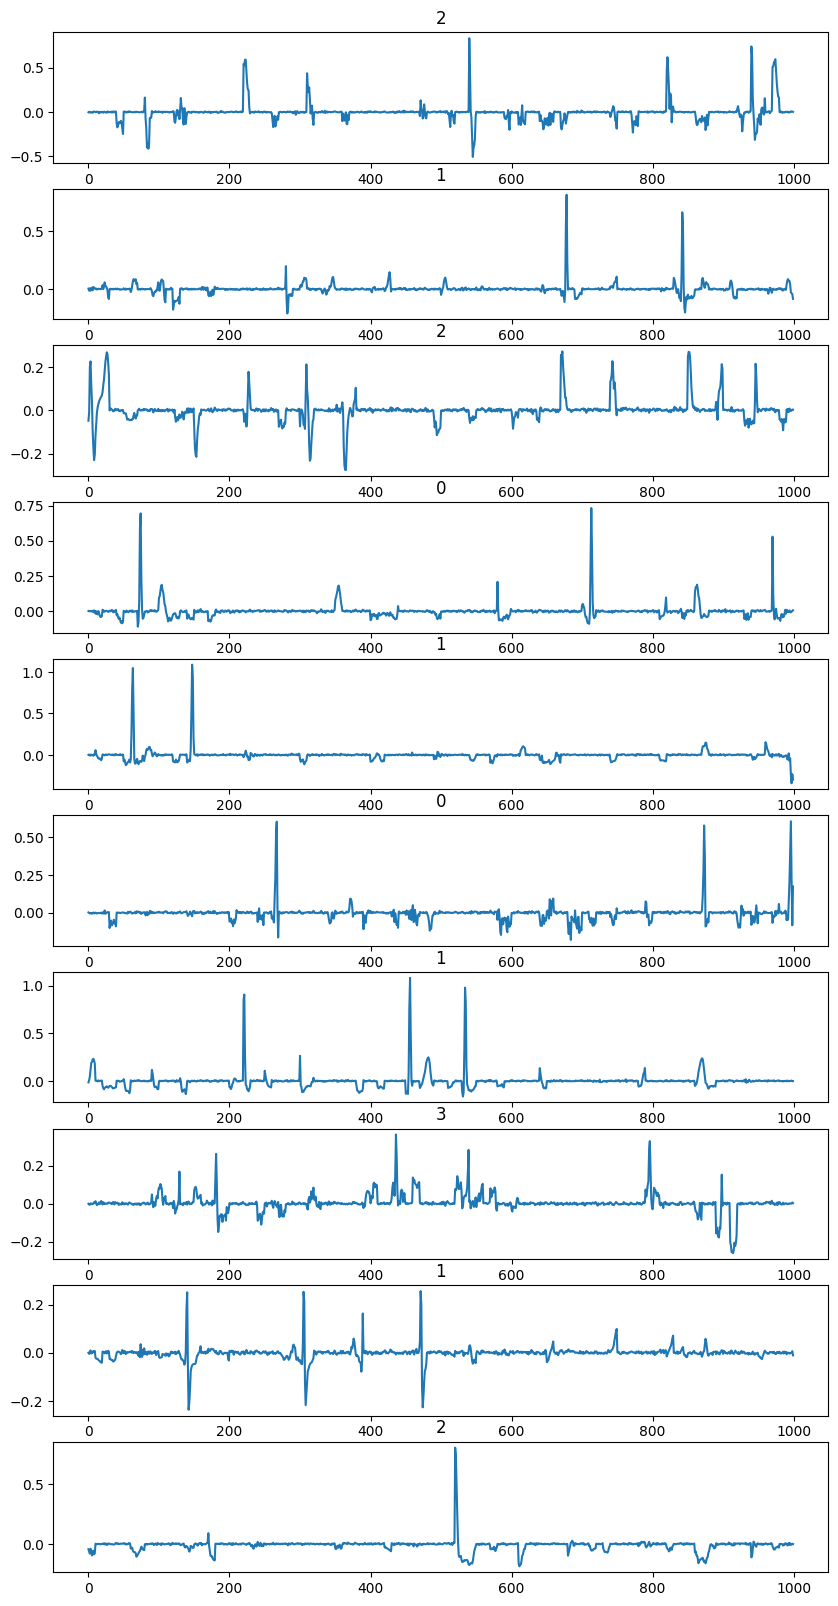

In [40]:
fig = plt.figure(figsize=(10, 20))
ch = 0
for i in range(10):
    plt.subplot(10, 1, i + 1)
    plt.plot(samp[i][ch])
    plt.title(lab[i])

In [11]:
tdata = train_data[0][0]  #test_data[1][0]
ttdata = torch.tensor(tdata).unsqueeze(0).to('cuda').float()

In [18]:
ttdata.shape

torch.Size([1, 12, 1000])

In [12]:
res, mask = model(ttdata)

In [13]:
mask

tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]], device='cuda:0')

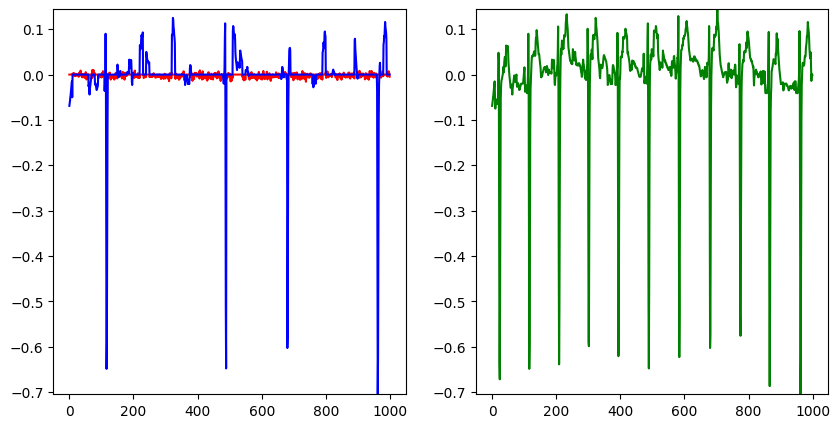

In [23]:
i = 8
masked = mask[0][i].cpu().detach().numpy()
mxlim = np.max(ttdata[0][i].cpu().detach().numpy())+0.002
mnlim = np.min(ttdata[0][i].cpu().detach().numpy())-.001
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
plt.ylim(mnlim,mxlim)
plt.plot(res[0][i].cpu().detach().numpy()*masked, c='r')
plt.plot(ttdata[0][i].cpu().detach().numpy() * (np.abs(masked - 1)), c='b')
ax = fig.add_subplot(122)
plt.ylim(mnlim,mxlim)
plt.plot(ttdata[0][i].cpu().detach().numpy(), c='g');

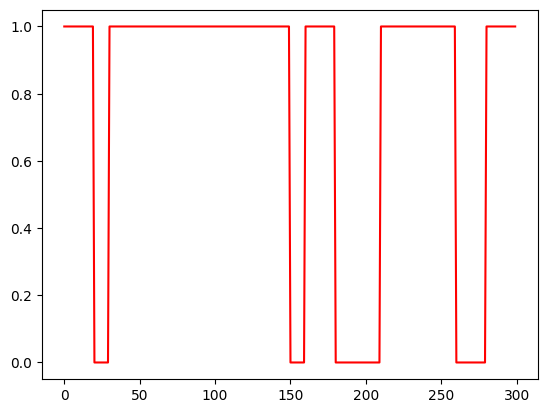

In [56]:
plt.plot(mask[0][0].cpu().detach().numpy(), c='r')

In [30]:
lmask = [
    0, 1,0 , 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1
]

# lmask = [
#     1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0
# ]

mask = torch.tensor(lmask)

emask = torch.ravel(torch.tensor([ [i] * config['model']['patch_size'] for i in lmask]) )


In [31]:
res = model.impute_one(ttdata, mask)

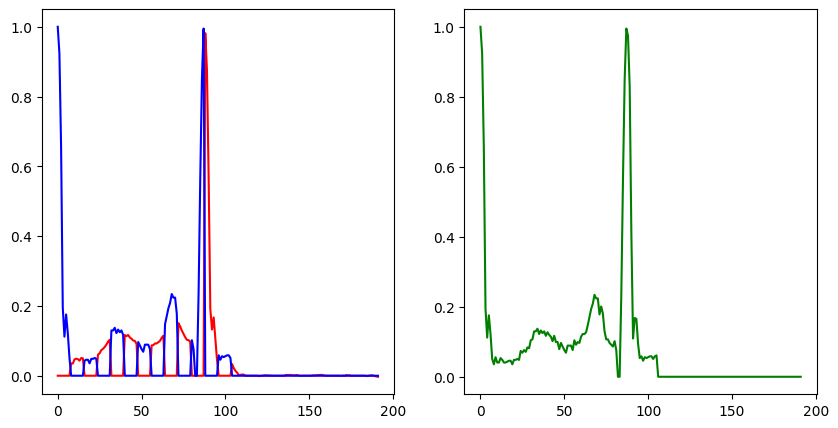

In [32]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
plt.plot(res[0][0].cpu().detach()*emask, c='r')
plt.plot(ttdata[0][0].cpu().detach() * (np.abs(emask - 1)), c='b')
ax = fig.add_subplot(122)
plt.plot(ttdata[0][0].cpu().detach().numpy(), c='g');

---

In [54]:
from ai4ha.data.series.PTBXLDataLoader import PTBXLtrain
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

In [55]:
orig = PTBXLtrain(dir="/home/bejar/bsc/Data/ptbxl_c",
                     padding=0, padalgo=None)

Loading data from /home/bejar/bsc/Data/ptbxl_c
PTBXL train NPZ True
X_train shape is (16427, 12, 1000)
y_train shape is (16427,)
NClasses: 7 [0 1 2 3 4 5 6]
PAD=0 PADALGO=None


In [56]:
odata = [d[0].squeeze() for d in orig]
sdata = np.array(odata)
length = 1000

In [57]:
datal = [int(d[1]) for d in orig]

In [58]:
import pandas as pd

In [76]:
model = 'PTBXLC-b128-AE-ExtraMAE_l4_h8_p10_m0.5_e32_mlTrue_nlTrue_pnormal-OPT-adamw-lr0.0001-SCplateau-LS-MAE'
path = f'/home/bejar/bsc/misiones/Series/Models/ExtraMAE/logs/{model}/logs/losslog.csv'
loss = pd.read_csv(path)
loss.tail(3)

,MSEloss
1636,0.029540
1637,0.029523
1638,0.029491


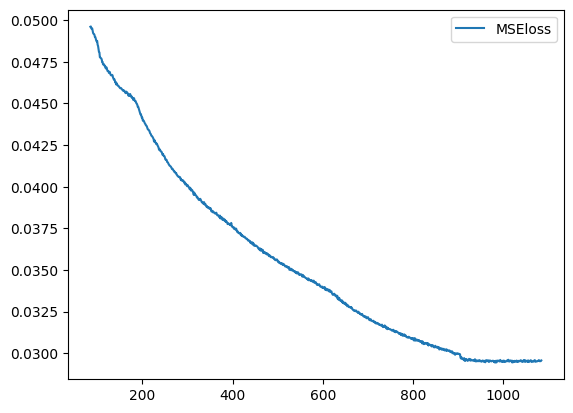

In [75]:
loss.iloc[-1000:].plot(y=['MSEloss']);

---

In [46]:
samples = np.load(f'/home/bejar/bsc/misiones/Series/Models/ExtraMAE/logs/{model}/samples/sampled_data.npz')

In [47]:
samp = samples['samples']
lab = samples['classes']
orig = samples['orig']
mask = samples['mask']


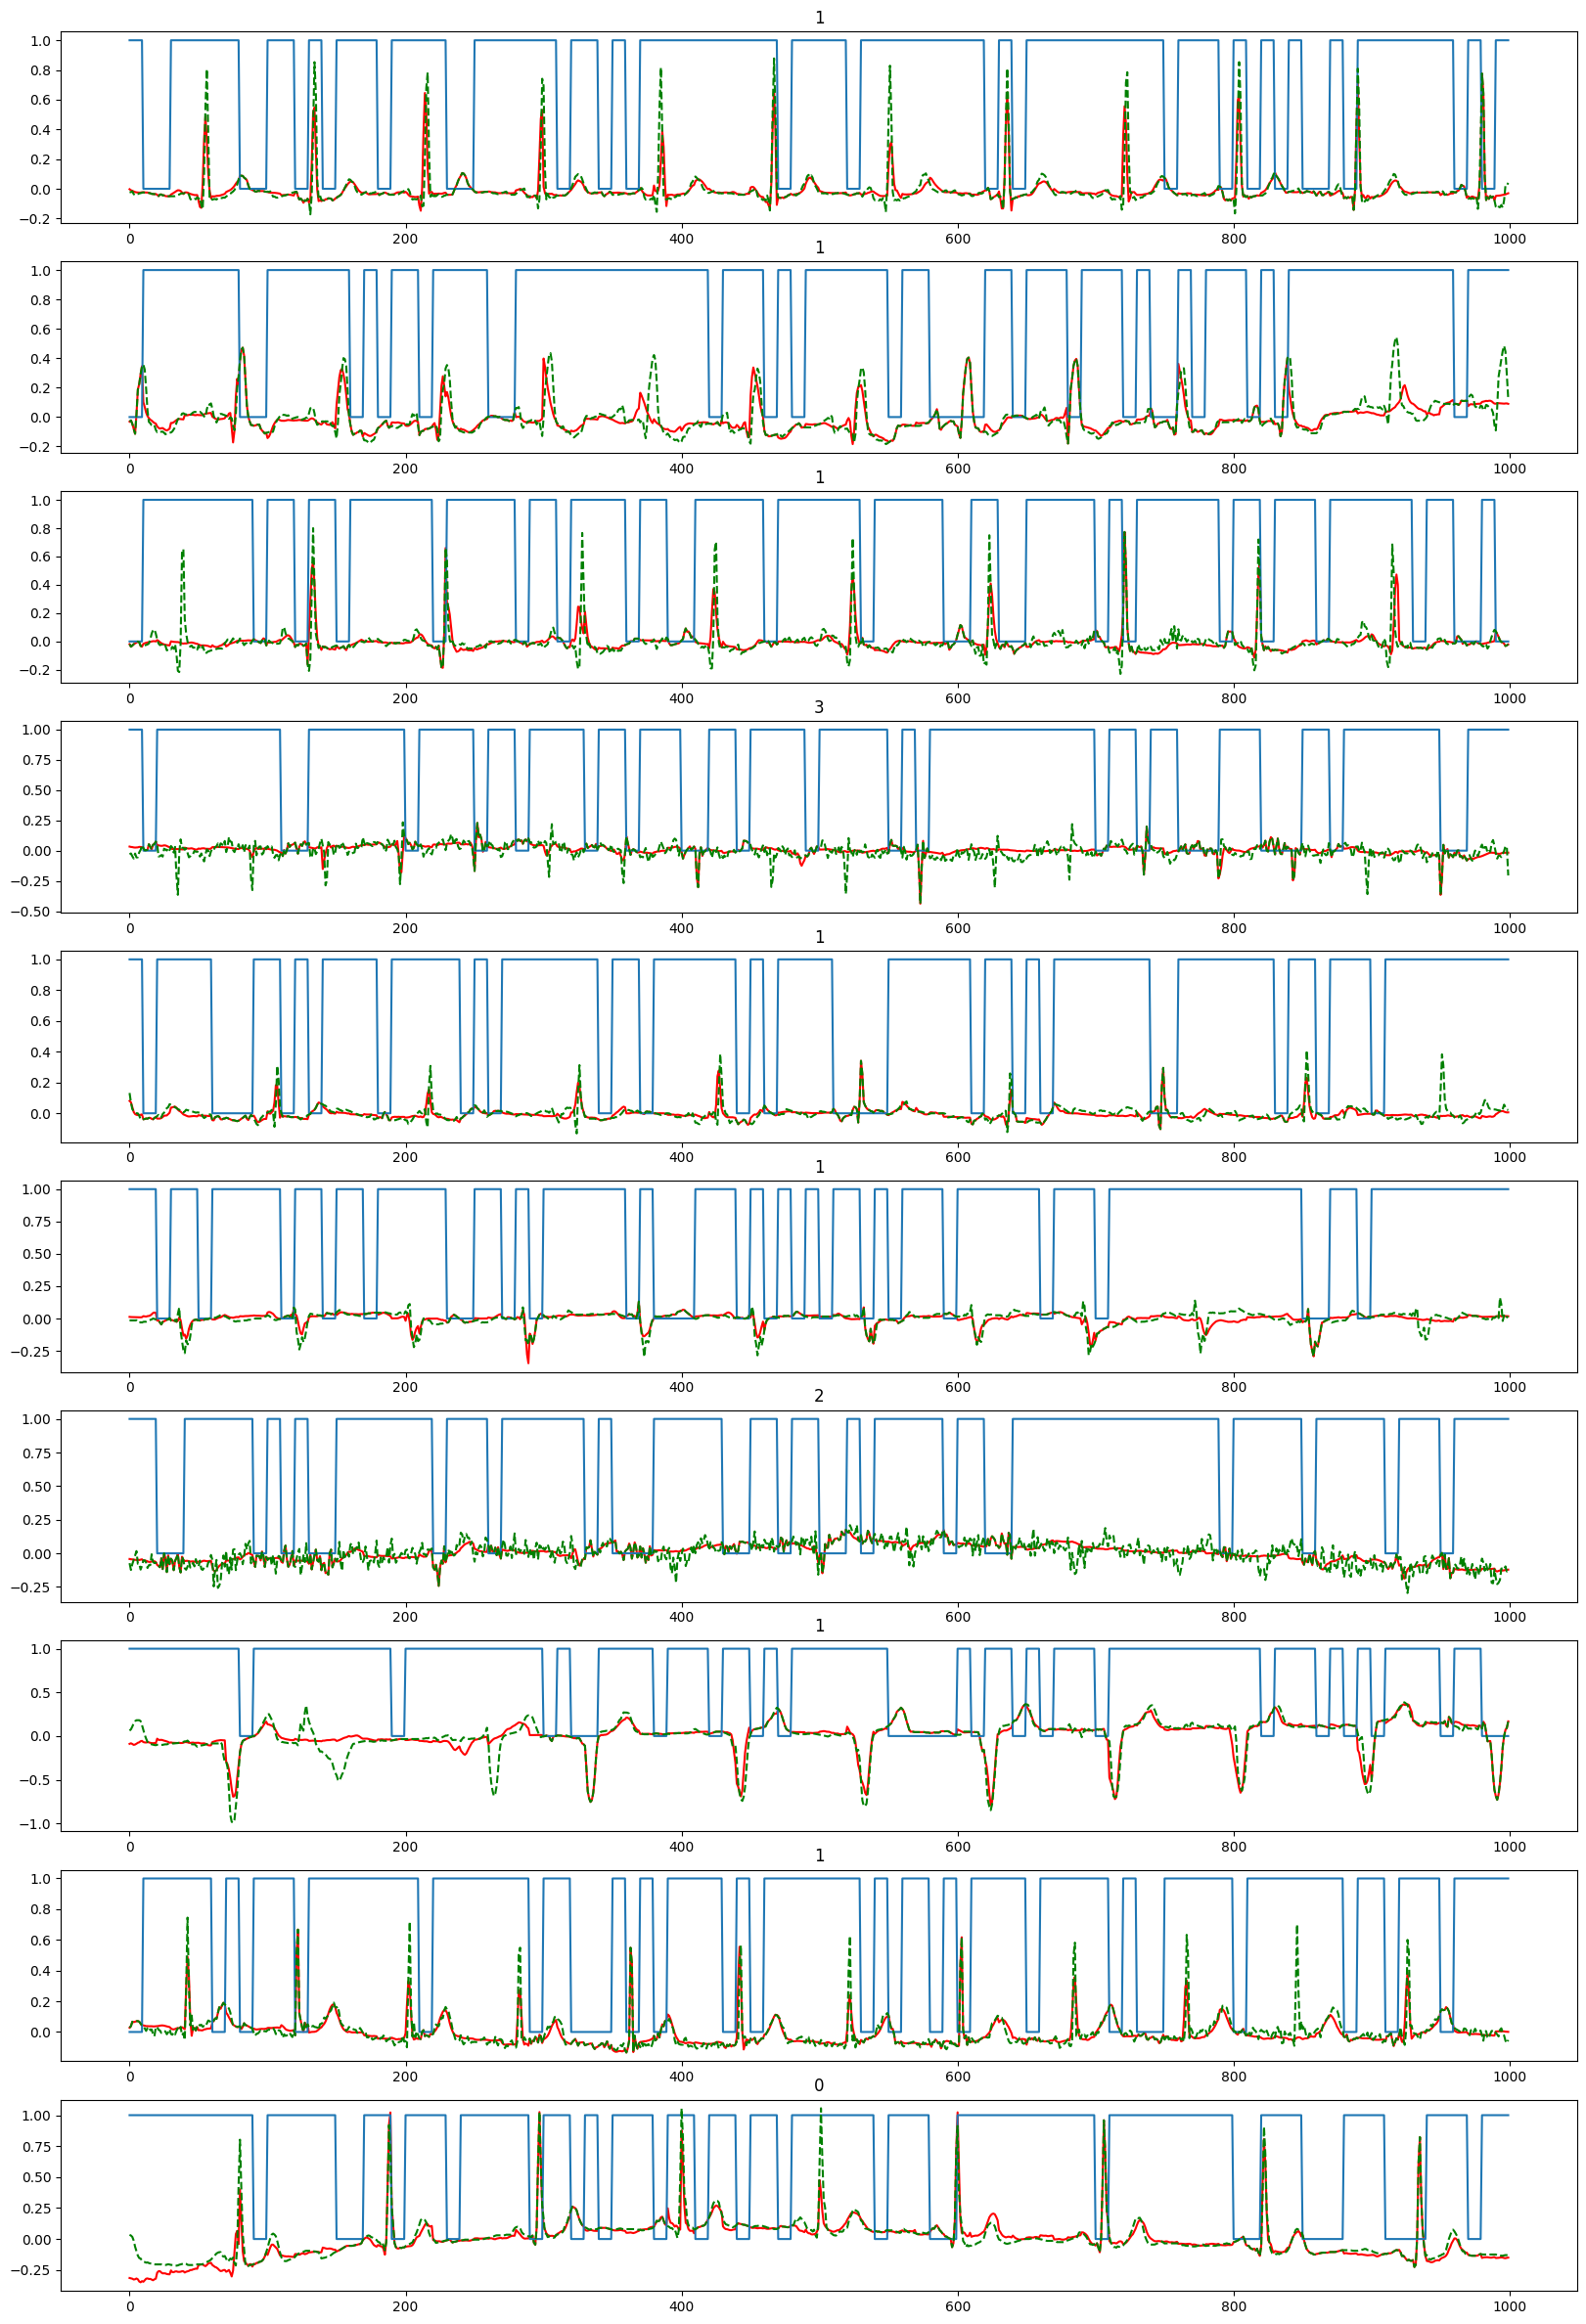

In [52]:
fig = plt.figure(figsize=(20, 30))
ch = 4
d = 10
for i in range(10):
    plt.subplot(10, 1, i + 1)
    plt.plot(samp[i+d][ch], c='r')
    plt.plot(mask[i+d][ch])
    plt.plot(orig[i+d][ch], 'g--')
    plt.title(lab[i+d])

In [59]:
length = 1000
d=0
all = np.concatenate((samp.squeeze()[:,d,:length], sdata[:,d,:length]), axis=0)

In [60]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=2000,
            init='random').fit_transform(all)


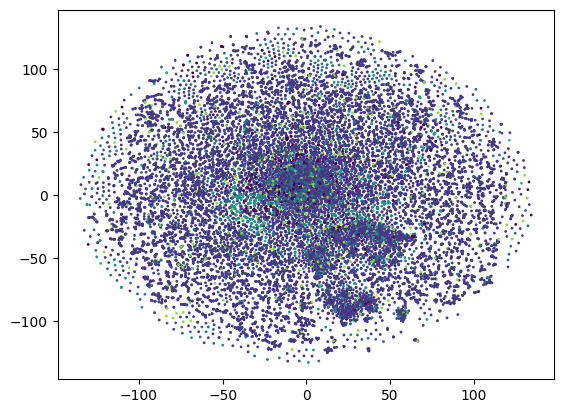

In [61]:
plt.scatter(tsne[samp.shape[0]:, 0], tsne[samp.shape[0]:, 1], c=datal, s=1, cmap='viridis');

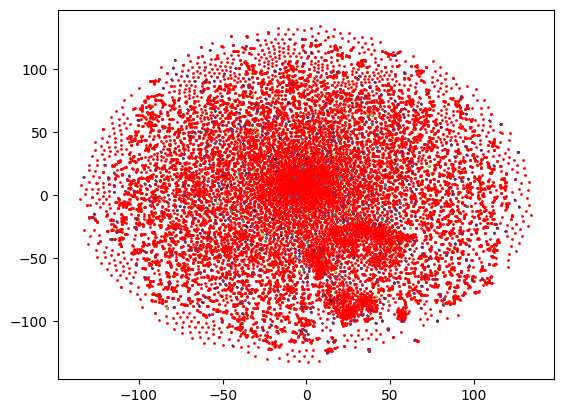

In [62]:
plt.scatter(tsne[samp.shape[0]:, 0], tsne[samp.shape[0]:, 1], c='r', s=1)
plt.scatter(tsne[:samp.shape[0], 0], tsne[:samp.shape[0], 1],c=lab,cmap='viridis', s=1, marker='x');